In [20]:
rm
library(data.table)
library(ggplot2)
library(maps)
library(mapdata)
library(dplyr)
library(DataExplorer)

#### Reading Data

In [21]:
df1 <- read.csv("global_power_plant_database.csv")
setDT(df1)

In [22]:
nrow(df1)
length(df1)

[1] 34936

[1] 36

In [23]:
df2 <- copy(df1)
df2[is.na(df2)] <- 0

In [24]:
#EDA Report using DataExplorer
create_report(df2)



processing file: report.rmd



  |..                                                                    |   2%
   inline R code fragments

  |...                                                                   |   5%
label: global_options (with options) 
List of 1
 $ include: logi FALSE

  |.....                                                                 |   7%
  ordinary text without R code

  |.......                                                               |  10%
label: introduce
  |........                                                              |  12%
  ordinary text without R code

  |..........                                                            |  14%
label: plot_intro
  |............                                                          |  17%
  ordinary text without R code

  |.............                                                         |  19%
label: data_structure
  |...............                                                       |  21%
  ordinary text without R c

output file: C:/Projects/Project 3/report.knit.md




"C:/PROGRA~1/Pandoc/pandoc" +RTS -K512m -RTS "C:/Projects/Project 3/report.knit.md" --to html4 --from markdown+autolink_bare_uris+tex_math_single_backslash --output pandoc1dbc25117567.html --lua-filter "C:\Users\rajat\AppData\Local\R\win-library\4.2\rmarkdown\rmarkdown\lua\pagebreak.lua" --lua-filter "C:\Users\rajat\AppData\Local\R\win-library\4.2\rmarkdown\rmarkdown\lua\latex-div.lua" --embed-resources --standalone --variable bs3=TRUE --section-divs --table-of-contents --toc-depth 6 --template "C:\Users\rajat\AppData\Local\R\win-library\4.2\rmarkdown\rmd\h\default.html" --no-highlight --variable highlightjs=1 --variable theme=yeti --mathjax --variable "mathjax-url=https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" --include-in-header "C:\Users\rajat\AppData\Local\Temp\RtmpAfRIJ3\rmarkdown-str1dbc7c59260c.html" 



Output created: report.html



#### Data Processing

In [25]:
#Converting MW to GWH for comparison
df3 <- df2[ ,lapply(.SD,sum), .SDcols = c('capacity_mw','generation_gwh_2018'), by = c("country_long", "primary_fuel")]
df3$capacity_gwh <- df3$capacity_mw * 24 *365/1000
df3$Difference <- df3$capacity_gwh - df3$generation_gwh_2018
head(df3)

country_long,primary_fuel,capacity_mw,generation_gwh_2018,capacity_gwh,Difference
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,Hydro,238.55,0,2089.698,2089.698
Afghanistan,Solar,20.00,0,175.200,175.200
Afghanistan,Gas,42.00,0,367.920,367.920
Albania,Hydro,1431.00,0,12535.560,12535.560
Albania,Other,98.00,0,858.480,858.480
Algeria,Solar,670.80,0,5876.208,5876.208


In [26]:
#Pivot up Energy totals
energy_totals <- df3[ ,lapply(.SD,sum), .SDcols = c('capacity_gwh'), by = c("country_long")]

energy_totals <- energy_totals[order(energy_totals$capacity_gwh, decreasing = TRUE)]

In [27]:
#Cast a Dataset for all forms of Energy

df4 <- dcast(df3, country_long ~ paste0(primary_fuel), fun.aggregate = sum, value.var = "capacity_gwh")

df4[is.na(df4)] <- 0

In [28]:
names(df4)

[1] "country_long"   "Biomass"        "Coal"           "Cogeneration"  
 [5] "Gas"            "Geothermal"     "Hydro"          "Nuclear"       
 [9] "Oil"            "Other"          "Petcoke"        "Solar"         
[13] "Storage"        "Waste"          "Wave and Tidal" "Wind"

In [29]:
#Getting Maximum Energy Generating Source of Power

df4$Max_Energy <- apply(df4[,2:16], 1, max)
df4$Max_Energy_Source <- apply(df4[,2:16], 1, function(row) names(df4[,2:16])[which.max(row)])
table(df4$Max_Energy_Source)


   Coal     Gas   Hydro Nuclear     Oil   Solar    Wind 
     28      42      62       3      28       3       1 

In [30]:
summary_energy <- df3[ ,lapply(.SD,sum), .SDcols = c('capacity_gwh'), by = c("primary_fuel")]
summary_energy <- summary_energy[order(summary_energy$capacity_gwh,decreasing=TRUE),]

summary_energy$`Capacity%` <- summary_energy$capacity_gwh*100/sum(summary_energy$capacity_gwh)

(summary_energy)

primary_fuel,capacity_gwh,Capacity%
<chr>,<dbl>,<dbl>
Coal,17218139.156,34.441027787
Gas,13079123.275,26.161854312
Hydro,9225678.269,18.453901362
Nuclear,3573307.018,7.147599701
Wind,2304350.670,4.609336976
Oil,2294057.496,4.588747788
Solar,1649615.954,3.299686940
Biomass,300304.202,0.600691240
Waste,129198.735,0.258433108


In [31]:
power_plant_cnt <- df4[ ,lapply(.SD,uniqueN), .SDcols = c('country_long'), by = c("Max_Energy_Source")]
power_plant_cnt

Max_Energy_Source,country_long
<chr>,<int>
Hydro,62
Gas,42
Oil,28
Coal,28
Nuclear,3
Solar,3
Wind,1


#### Data Visualizations

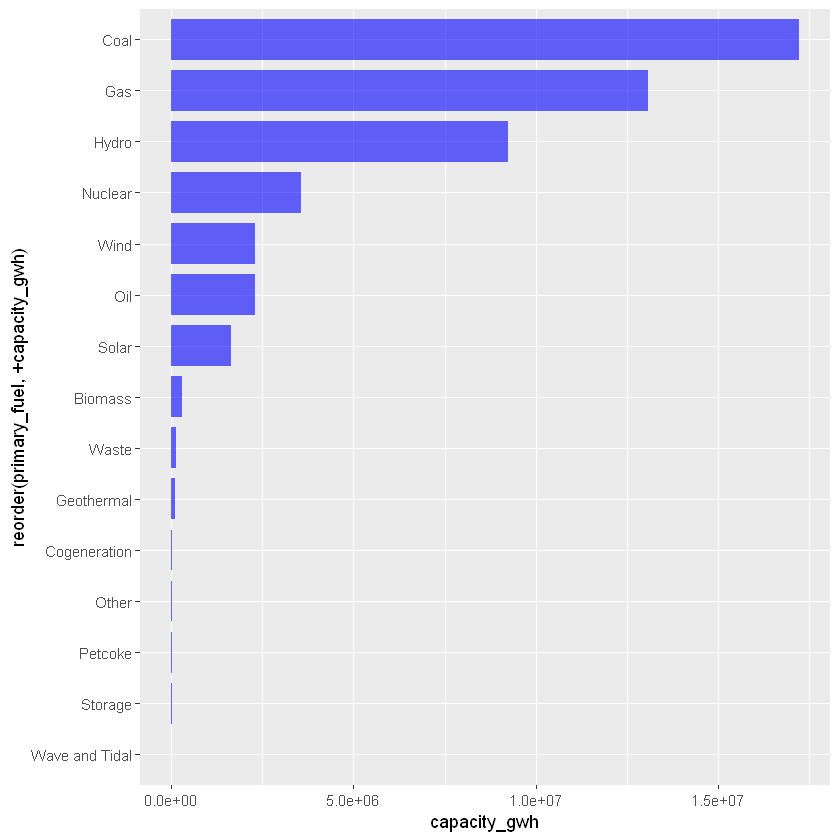

In [32]:
#Bar Plot Showcasing Major Power Sources 

ggplot(summary_energy, aes(x=reorder(primary_fuel, +capacity_gwh), y=capacity_gwh)) + 
  geom_bar(stat = "identity", fill="blue", alpha=.6, width=.8) +
  coord_flip()

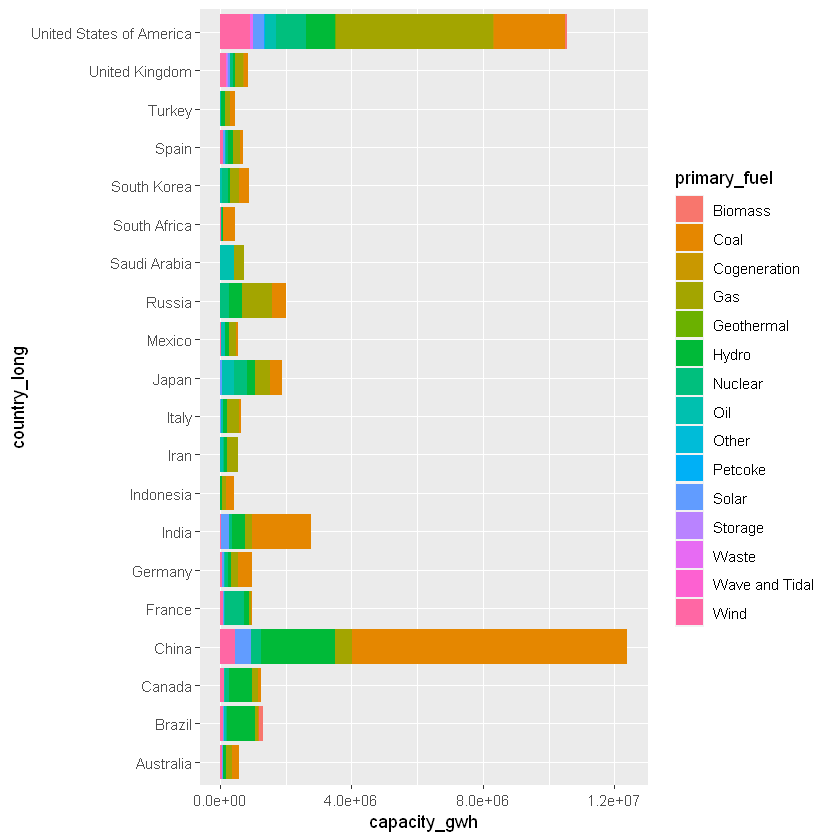

In [33]:
# Stacked Bar Chart of Top 20 Energy Consuming Nations

ggplot(df3[country_long %in% energy_totals[1:20]$country_long], aes(fill=primary_fuel, y=capacity_gwh, x=country_long)) + 
    geom_bar(position="stack", stat="identity")+
    coord_flip()

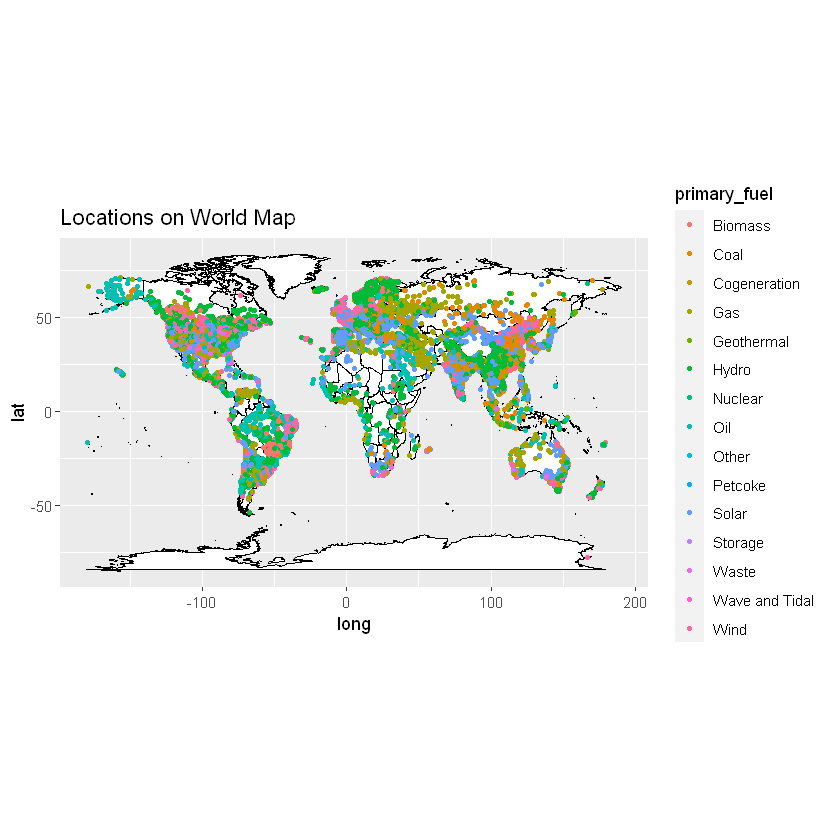

In [34]:
#All Power Plants around thw world

world_map <- map_data("world")

world_plot <- ggplot() +
  geom_polygon(data = world_map, aes(x = long, y = lat, group = group), color = "black", fill = "white") +
  coord_fixed(1.3) +
  theme()

world_plot_with_points <- world_plot +
  geom_point(data = df1, aes(x = longitude, y = latitude, color = primary_fuel), size = 1) +
  labs(title = "Locations on World Map")

world_plot_with_points


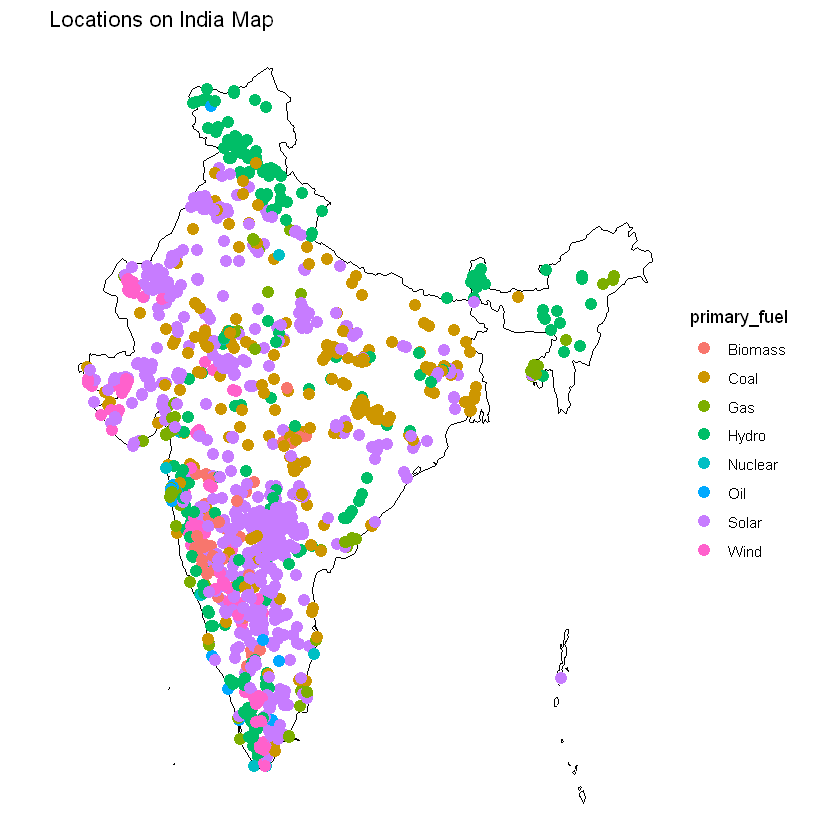

In [35]:
#Power Plants of India Mapped

india_map <- map_data("world", region = "India")

india_plot <- ggplot() +
  geom_polygon(data = india_map, aes(x = long, y = lat, group = group), color = "black", fill = "white") +
  coord_fixed(1.3) + 
  theme_void()

india_plot_with_points <- india_plot +
  geom_point(data = df1[country_long == "India"], aes(x = longitude, y = latitude, color = primary_fuel), size = 3) +
  labs(title = "Locations on India Map")

india_plot_with_points


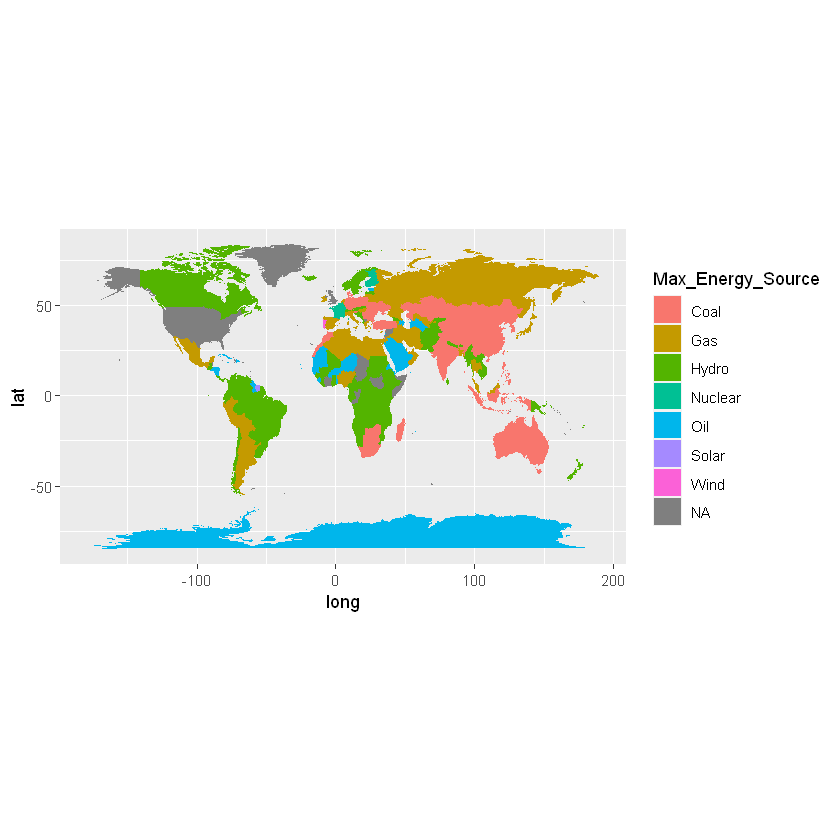

In [36]:
#Major Source of Electricity around the world

world <- map_data("world")

world %>%
  merge(df4, by.x = "region", by.y = "country_long", all.x = T) %>%
  arrange(group, order) %>%
  ggplot(aes(x = long, y = lat, group = group, fill = Max_Energy_Source)) + 
  coord_fixed(1.3) +  # To keep the aspect ratio close to a sphere
  geom_polygon()

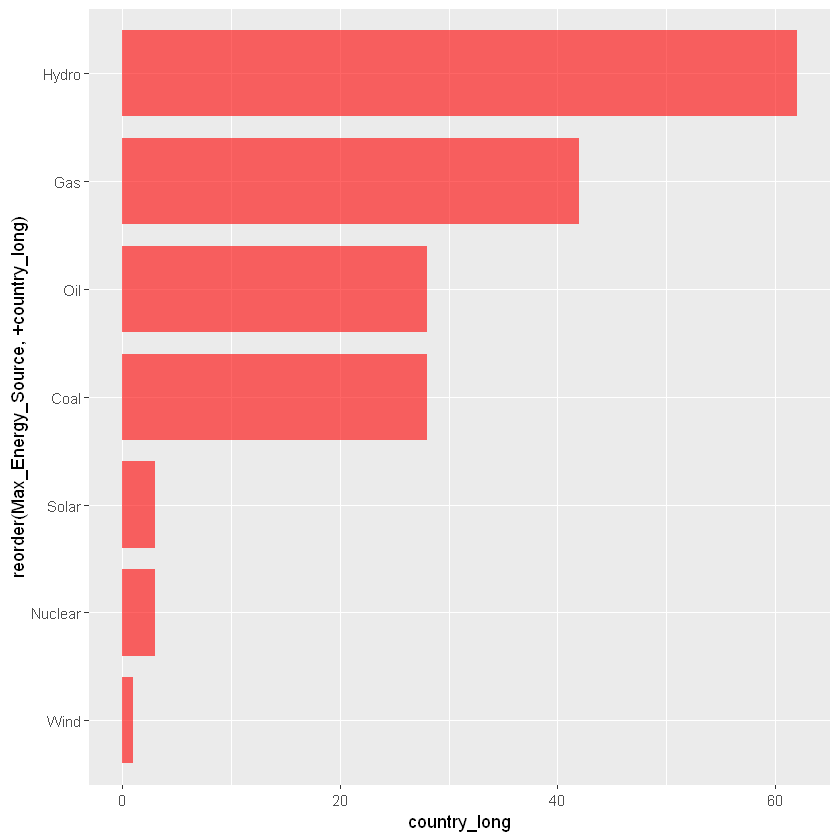

In [37]:
#Major Power Sources in Different Countries
ggplot(power_plant_cnt, aes(x=reorder(Max_Energy_Source, +country_long), y=country_long)) + 
  geom_bar(stat = "identity", fill="red", alpha=.6, width=.8) +
  coord_flip()